In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt 
from scipy import interpolate
import random
import math
import torch
import copy
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.svm import SVC

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import gc
import mads_dl

from PIL import Image
from IPython.display import Image
import matplotlib.cm as cm
import seaborn as sns
torch.manual_seed(1)
from classes import *
# set all columns to be displayed
pd.set_option('display.max_columns', None)

loaddata = LoadData()


2024-11-20 11:35:35.666157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732098935.747651    5550 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732098935.762303    5550 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 11:35:35.876372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Classes

## Loading Data Classes

In [2]:
# 'FA_20231206_2H_yeast_Pyruvate-d3_1.ser.csv'
# 'FA_20240517_2H_yeast_Nicotinamide-d4 _9.csv'
# 'FA_20240213_2H_yeast_Fumarate-d2_9.csv
file = str(Path('FA_20231123_2H Yeast_Fumarate-d2_12 .csv'))
substrates = loaddata.get_substrate_list(file)
metabolites = loaddata.get_metabolite_list(file)
substrates = [float(i) for i in substrates]
metabolites = [float(i) for i in metabolites]
path_list = loaddata.load_data(file)

In [3]:
print(substrates, metabolites)

[6.653, 4.7] [4.368, 2.474]


# Step 1: Loading the data

In [4]:
# shapes of all the csv files
path_list2 = loaddata.load_data('.csv')

for path in path_list2:
    df = pd.read_csv(path)
    print(df.shape)

(632, 51)
(622, 236)
(806, 151)
(1063, 51)
(837, 238)
(654, 51)
(585, 236)
(960, 131)
(855, 131)
(577, 236)
(679, 151)
(1429, 131)
(1583, 131)
(1170, 236)
(966, 51)
(1527, 131)
(841, 41)
(2003, 131)
(843, 238)
(859, 236)
(706, 131)
(1226, 131)
(880, 131)
(779, 131)
(695, 131)
(778, 51)
(636, 237)
(653, 131)
(1045, 131)
(925, 71)
(793, 236)
(718, 238)
(782, 236)
(2122, 131)
(1279, 131)
(1632, 131)
(941, 238)
(537, 236)
(1796, 101)
(890, 237)
(823, 131)
(1503, 131)
(861, 151)
(681, 236)
(1147, 51)
(755, 131)
(608, 238)
(1480, 237)
(2268, 131)
(1045, 181)
(1023, 51)
(1418, 238)
(691, 236)
(735, 131)
(655, 236)
(1139, 181)
(921, 131)
(1675, 131)
(673, 236)
(645, 238)
(1074, 131)
(908, 51)
(957, 131)
(877, 40)
(1297, 131)
(951, 131)
(1594, 131)
(799, 131)
(776, 236)
(971, 237)
(1675, 131)
(1178, 237)
(2072, 131)
(898, 51)


In [5]:
for file in path_list:
    df = pd.read_csv(file)
    print(df.shape)

(2268, 131)


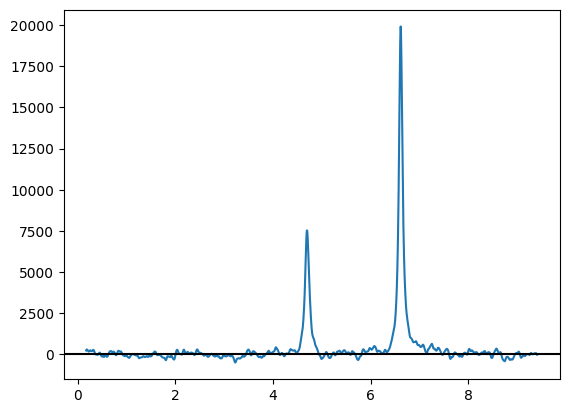

In [6]:
for i in range(len(path_list)):
    df = pd.read_csv(path_list[i])
    

    x = df.iloc[:,0]
    y = df.iloc[:, 1]

    #print(df.shape)

    plt.plot(x,y)

# show x  lines
plt.axhline(y=0, color='k')
plt.show()

# Step 2: Generating synthetic Data for - FA_20231113_2H_yeast_Pyruvate-d3_1.csv

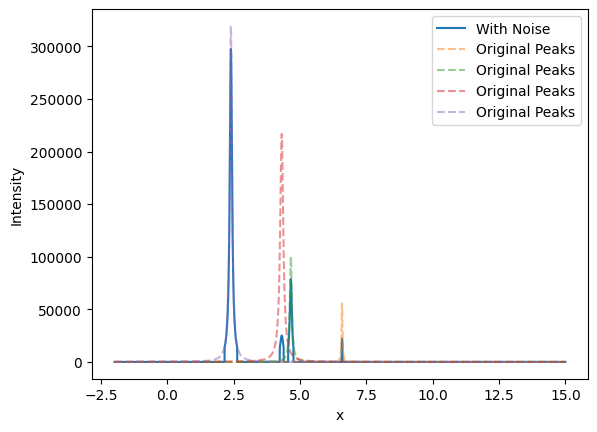

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Lorentzian function
def lorentzian(x, x0, gamma, height):
    return height * (gamma / ((x - x0)**2 + gamma**2))

def gaussian_curve(x, mu=0, sigma=1, height=1):
    """
    Gaussian function with specified height at the peak.
    
    Parameters:
    - x: numpy array or scalar, the input values.
    - mu: float, the mean/center of the curve (default 0).
    - sigma: float, the standard deviation of the Gaussian curve (default 1).
    - height: float, the desired height of the peak of the Gaussian curve.
    
    Returns:
    - numpy array or scalar representing the Gaussian curve.
    """
    return height * np.exp(-0.5 * ((x - mu) / sigma)**2)

def pseudo_voigt(x, mu=0, sigma=1, gamma=1, eta=0.5, height=1):
    """
    Pseudo-Voigt function: a linear combination of Gaussian and Lorentzian curves.

    Parameters:
    - x: numpy array or scalar, the input values.
    - mu: float, the mean/center of the curve.
    - sigma: float, the standard deviation of the Gaussian component.
    - gamma: float, the half-width at half-maximum (HWHM) of the Lorentzian component.
    - eta: float, the mixing parameter (0 = pure Gaussian, 1 = pure Lorentzian).

    Returns:
    - numpy array or scalar representing the pseudo-Voigt profile.
    """
    if not (0 <= eta <= 1):
        raise ValueError("Eta must be between 0 and 1.")
    
    gaussian = gaussian_curve(x, mu, sigma, height=height)
    lorentzian_val = lorentzian(x, mu, gamma, height=height)
    return eta * lorentzian_val + (1 - eta) * gaussian




def generate_random_spectrum(peak_list, spectrum_length=3000):

    # Generate random spectrum with Lorentzian peaks
    x = np.linspace(-2, 15, spectrum_length)  # x range
    y = np.zeros_like(x)          # initialize y as zeros
    mask = np.zeros_like(x)       # mask to identify peak regions

    # Add random Lorentzian peaks
    x0_parms = []
    gamma_parms = []
    height_parms = []

    x0_substrate_parms = []
    gamma_substrate_parms = []
    height_substrate_parms = []

    # let peakist ranomd jump left and right

    peak_list = np.array(peak_list) + np.random.uniform(-0.1, 0.1)

    for peak_pos in peak_list:
        metabolism_x0 = peak_pos + np.random.uniform(-0.02, 0.02)
        
        metabolism_gamma = np.random.uniform(0.009, 0.08)  # Random width (gamma)
        metabolism_height = np.random.uniform(100, 20000)  # Random height
        # select random function:
        #peak_lorenz = gaussian_curve(x=x, mu=metabolism_x0, sigma=metabolism_gamma, height=metabolism_height)

        peak_lorenz = pseudo_voigt(x=x, mu=metabolism_x0, sigma=metabolism_gamma, gamma=metabolism_gamma, eta=np.random.uniform(0, 1), height=metabolism_height)

        #peak_lorenz = lorentzian(x, metabolism_x0, metabolism_gamma, metabolism_height)
        y = np.maximum(y, peak_lorenz)  # Use maximum to avoid summing peaks

        # Create a mask to identify regions near the peaks (exclude noise here)
        mask += peak_lorenz > (0.1 * metabolism_height)  # Masking regions where peak height is significant

        # Append the parameters for the peak
        x0_parms.append(metabolism_x0)
        gamma_parms.append(metabolism_gamma)
        height_parms.append(metabolism_height)



    # Add noise only outside the peak regions
    random_noise_level = np.random.uniform(0, df.max().max())
    gaussian_noise = np.random.normal(0, 500, 3000)
    laplace_noise = np.random.laplace(0, 500, 3000)

    # choose random between noise1 and noise2
    noise = gaussian_noise if np.random.rand() > 0.5 else laplace_noise

    #noise = np.random.normal(10, random_noise_level, spectrum_length)

    # smooth the noise with gaussian filter
    sigma = random_noise_level /1
    #noise = gaussian_filter1d(noise, sigma=sigma)
    # rollwing window mean
    noise = np.convolve(noise, np.ones(50)/50, mode='same')
    
    
        
    y_noisy = y + noise * (mask == 0)  # Add noise only where mask is 0 (outside peaks)

    # set everything below treshold to zero
    
    # Calculate the 80 percentile 
    percentile = np.percentile(y_noisy, 95)

    y_clean = np.where(y_noisy < percentile, 0, y_noisy)

    #print(y_noisy.shape, y_clean.shape)

    

    return x, y_clean, np.array(x0_parms), np.array(gamma_parms), np.array(height_parms)


# ----

#peak_list = [2.323, 4.7, 1.201]
substrates_list = substrates + metabolites
x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise")

for x0, gamma, height in zip(x0_parms, gamma_parms, height_parms):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label="Original Peaks", alpha=0.5)  
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()
plt.show()


# Step 3: Fill Up Original Data 

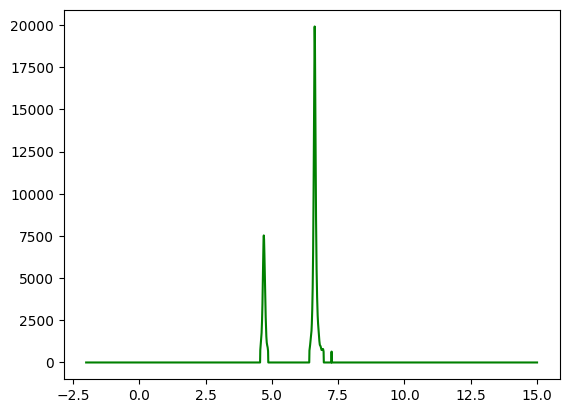

(4177, 2)


,x,y
0,-2.000000,0.0
1,-1.995927,0.0
2,-1.991855,0.0
3,-1.987782,0.0
4,-1.983710,0.0
...,...,...
4172,14.983135,0.0
4173,14.987208,0.0
4174,14.991280,0.0
4175,14.995353,0.0


In [8]:



def interpolate_to_shape(x_original, y_original, spectrum_lenth=3000):
    """_summary_

    # Originaldaten
    y_original = df.iloc[:, 1]
    x_original = df.iloc[:, 0]

    Args:
        df (_type_): _description_
    """


    # Neue x-Werte (stellen Sie sicher, dass diese innerhalb des Bereichs von x_original liegen)
    x_new = np.linspace(x_original.min(), x_original.max(), spectrum_lenth)

    # Interpolierte Daten
    interpolated_data = interpolate.interp1d(x_original, y_original, kind='linear')(x_new)
    
    df = pd.DataFrame({'x': x_new, 'y': interpolated_data})
    return df

def fill_df(df):
    """If Data is not ranging from -2 to 10, fill the data with noise
    
    """
    treshold = 95

    # renmame the columns
    df.columns = ['x', 'y']
    x = df.loc[:, 'x']
    y = df.loc[:, 'y']



    # Calculate the step size of the x values
    x_diff = np.diff(x)
    step = np.mean(x_diff)
    
    # Take sample range for the noise
    x_range_lower = 0
    x_range_upper = 100

    # get sample data of the noise
    x_sample = x[x_range_lower:x_range_upper]
    y_sample = y[x_range_lower:x_range_upper]

    # get the max and min values of the sample data
    y_min, y_max = (y_sample.min()), abs(y_sample.max())
    #print(y_min, y_max)

    # get the min max of the x values
    x_min, x_max = x.min(), x.min()

    if x_min > -2:


        # create values in n steps
        x_new = np.arange(-2, x.iloc[0], step)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(0, y_max, len(x_new))


        
        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        #percentile = np.percentile(y_new, treshold)

        #y_new = np.where(y_new < percentile, 0, y_new)

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([data, df], axis=0)
        df.reset_index(drop=True, inplace=True)

    if x_max < 15:
    
        # create values in n steps
        x_new = np.arange(x.iloc[-1], 15, step)
        #print(x_new)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(0, y_max, len(x_new))

        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        #percentile = np.percentile(y_new, treshold)

        #y_new = np.where(y_new < percentile, 0, y_new)

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([df, data], axis=0)
        df.reset_index(drop=True, inplace=True)

    percentile = df['y'].quantile(treshold/100)

    df.loc[df['y'] < percentile, 'y'] = 0

    #display(df)
                
    return df


df_fill = df.iloc[:, [0,1]]
#print(df_fill.head())
df_filled = fill_df(df_fill)
#print(df_filled.head())

# plot 
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1], color='green')
#plt.plot(df_fill.iloc[:, 0], df_fill.iloc[:, 1], color='blue', alpha=0.2)
plt.show()
print(df_filled.shape)
display(df_filled)

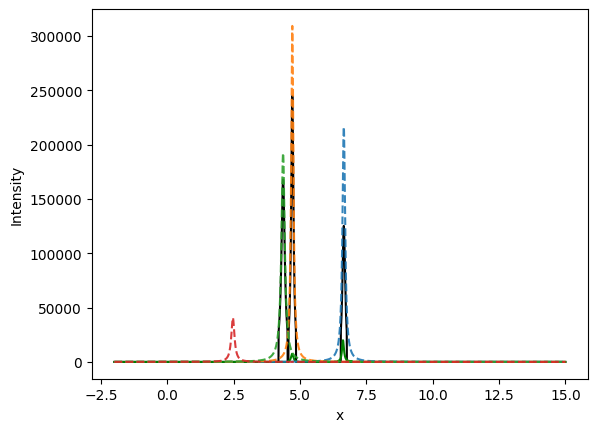

In [9]:
# visualize random spectra and real spectra


substrates_list = substrates + metabolites
x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise", color='black')
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1], color='green')
for x0, gamma, height in zip(x0_parms, gamma_parms, height_parms):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label="Original Peaks", alpha=0.9)  



#plt.plot(df_fill.iloc[:, 0], df_fill.iloc[:, 1], color='blue', alpha=0.2)
plt.xlabel('x')
plt.ylabel('Intensity')
plt.show()

# Step 3: Bring data to same shape

(3000, 2)


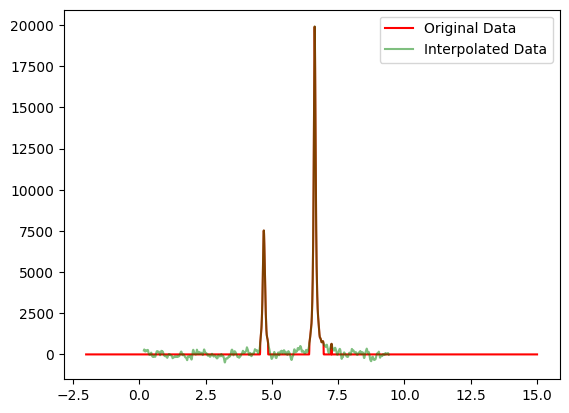

In [10]:

# Interpoliere die Werte, um die Größe des DataFrames zu erweitern
df_interpolated = interpolate_to_shape(df_filled.iloc[:, 0], df_filled.iloc[:, 1], spectrum_lenth=3000)

# Form des interpolierten DataFrames
print(df_interpolated.shape)

# Plot the interpolated data
#plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1])
plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], color='red',)
plt.plot(df.iloc[:, 0], df.iloc[:, 1], color='green', alpha=0.5)
plt.legend(['Original Data', 'Interpolated Data', 'Sum'])
plt.show()

# Step 4: Bring Data to shape for Transformer

In [11]:
df_interpolated.shape

(3000, 2)

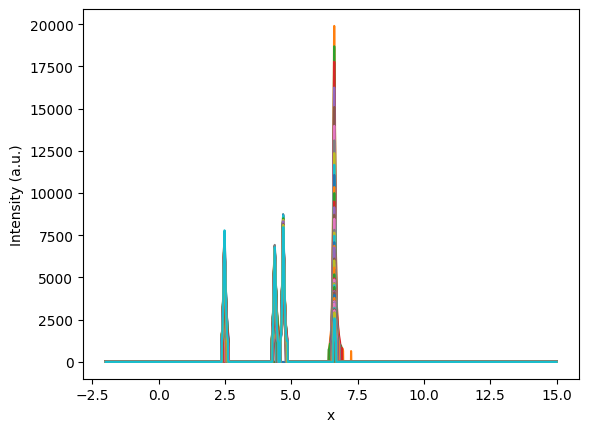

In [12]:
for i in range(df.shape[1]-1):

    df_filled = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_filled.loc[:,'x'], df_filled.loc[:,'y'], spectrum_lenth=3000)
    #plt.plot(df_filled.loc[:,'x'], df_filled.loc[:,'y'], '-', label='Original Data')
    plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], '-', label='Interpolated Data')

# data_train_tensor & y_train
substrates_list = substrates + metabolites
x_synth, y_synth, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)


#plt.plot(x_synth, y_synth, label="With Noise")
plt.xlabel('x')
plt.ylabel('Intensity (a.u.)')

plt.show()

# Generate training Dataset 

In [13]:

num_samples = 20000

x_data = []
y_data = []
x0_parms_list = []
gamma_parms_list = []
height_parms_list = []
for i in range(num_samples):
    # data_train_tensor & y_train
    substrates_list = substrates + metabolites
    x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)
    x_data.append(x)
    y_data.append(y_noisy)
    x0_parms_list.append(x0_parms)
    gamma_parms_list.append(gamma_parms)
    height_parms_list.append(height_parms)




# Umwandeln der lists in Tensoren
x_data = torch.tensor(x_data)
data = torch.tensor(y_data) # Data: Noisy Spectra which is input to the model
x_params_tensor = torch.tensor(x0_parms_list) # Target: 
gamma_params_tensor = torch.tensor(gamma_parms_list)
height_params_tensor = torch.tensor(height_parms_list)

target = torch.cat((x_params_tensor, gamma_params_tensor, height_params_tensor), dim=1)



# Überprüfen der Formen
print(f"x_data shape: {x_data.shape}")
print(f"data shape: {data.shape}")
print(f"x_params_tensor shape: {x_params_tensor.shape}")
print(f"gamma_params_tensor shape: {gamma_params_tensor.shape}")
print(f"height_params_tensor shape: {height_params_tensor.shape}")
print(f"target shape: {target.shape}")
print('\n')

/tmp/ipykernel_5550/2502958047.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x_data = torch.tensor(x_data)


x_data shape: torch.Size([20000, 3000])
data shape: torch.Size([20000, 3000])
x_params_tensor shape: torch.Size([20000, 4])
gamma_params_tensor shape: torch.Size([20000, 4])
height_params_tensor shape: torch.Size([20000, 4])
target shape: torch.Size([20000, 12])




In [14]:

def scale_data(data, target):
    """Scale the data
    
    Args:
        x_data (_type_): _description_
        y_data (_type_): _description_
    """
    # Skalieren Sie die Daten
    data_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    print(f'Before Scaling: {data.shape}')
    print(f'Before Scaling: {target.shape}')

    # Reshape the data before scaling
    data = data.reshape(data.shape[0], -1)
    target = target.reshape(target.shape[0], -1)

    print(f'After Reshaping: {data.shape}')
    print(f'After Reshaping: {target.shape}')

    # Skalieren Sie die x-Daten
    data_scaled = data_scaler.fit_transform(data)
    target_scaled = target_scaler.fit_transform(target)
    
    print(f'After Scaling: {data_scaled.shape}')
    print(f'After Scaling: {target_scaled.shape}')


    return data_scaled, target_scaled, data_scaler, target_scaler
    

# Skalieren Sie die Daten
data_scaled, target_scaled, data_scaler, target_scaler = scale_data(data, target)

Before Scaling: torch.Size([20000, 3000])
Before Scaling: torch.Size([20000, 12])
After Reshaping: torch.Size([20000, 3000])
After Reshaping: torch.Size([20000, 12])
After Scaling: (20000, 3000)
After Scaling: (20000, 12)


In [15]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Aufteilen der Daten in Trainings- und Testsets
data_train, data_tmp, target_train, target_tmp = train_test_split(data, target, 
                                                    test_size=0.4,
                                                    shuffle=True,
                                                    random_state=1)
data_val, data_test, target_val, target_test = train_test_split(data_tmp, target_tmp,
                                                    test_size=0.5,
                                                    shuffle=True,
                                                    random_state=1)

# import StandardScaler
from sklearn.preprocessing import StandardScaler

# Skalieren der Daten
data_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Skalieren von data train und test
data_train_sc = data_scaler.fit_transform(data_train)
data_val_sc = data_scaler.transform(data_val)
data_test_sc = data_scaler.transform(data_test)

# Skalieren von target train und test
target_train_sc = target_scaler.fit_transform(target_train)
target_val_sc = target_scaler.transform(target_val)
target_test_sc = target_scaler.transform(target_test)


# Konvertieren in Tensoren
data_train_tensor = torch.tensor(data_train_sc, dtype=torch.float32)
data_val_tensor = torch.tensor(data_val_sc, dtype=torch.float32)
data_test_tensor = torch.tensor(data_test_sc, dtype=torch.float32)
target_train_tensor = torch.tensor(target_train_sc, dtype=torch.float32)
target_val_tensor = torch.tensor(target_val_sc, dtype=torch.float32)
target_test_tensor = torch.tensor(target_test_sc, dtype=torch.float32)





# # Reshape the tensors for the model
# target_train_tensor = target_train_tensor.reshape(target_train_tensor.shape[0], -1)
# target_val_tensor = target_val_tensor.reshape(target_val_tensor.shape[0], -1)

# Überprüfen der Tensoren
print(f"Data Train Shape: {data_train_tensor.shape}")
print(f"Data Val Shape: {data_val_tensor.shape}")
print(f"Data Test Shape: {data_test_tensor.shape}")
print(f"Target Train Shape: {target_train_tensor.shape}")
print(f"Target Val Shape: {target_val_tensor.shape}")
print(f"Target Test Shape: {target_test_tensor.shape}")

Data Train Shape: torch.Size([12000, 3000])
Data Val Shape: torch.Size([4000, 3000])
Data Test Shape: torch.Size([4000, 3000])
Target Train Shape: torch.Size([12000, 12])
Target Val Shape: torch.Size([4000, 12])
Target Test Shape: torch.Size([4000, 12])


# LSTM 

In [16]:
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob):
#         super(NeuralNetwork, self).__init__()

#         self.reduce = nn.Linear(3000, hidden_size)

#         # Define LSTM with correct hidden size
#         self.lstm = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)

#         # Fully connected layers with corrected input sizes
#         self.fc1 = nn.Sequential(
#             nn.Linear(hidden_size, 128),  # Match hidden_size with the output of LSTM
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(128, 32),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc3 = nn.Sequential(
#             nn.Linear(32, 16),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(16, output_size)

#     def forward(self, x):
#         # Check shape before reducing
#         #print(f"Input shape before reduction: {x.shape}")  # For debugging
#         x = self.reduce(x)  # This should expect (batch_size, 3000)
        

#         # Reshape for LSTM input
#         x = x.reshape(x.shape[0], 1, -1)  # Reshape to (batch_size, seq_len, input_size)
#         #print(f"Shape after reduction: {x.shape}")

#         batch_size = x.shape[0]
        
#         # Initialize hidden and cell states with hidden_size instead of input_size
#         h_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)
#         #c_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)

#         # Pass data through LSTM
#         x, _ = self.lstm(x, (h_0))
#         x = x[:, -1, :]  # Take the output from the last time step

#         # Pass data through fully connected layers
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)

#         # Final output
#         output = self.output(x)
#         return output
    
#     def predict(self, X):
#         '''
#         Use the model to predict for the values in the test set.
#         Return the prediction
#         '''
#         model.eval()
#         with torch.no_grad():
#             return model(X)


In [17]:
print(data_train_tensor.shape, target_train_tensor.shape)

torch.Size([12000, 3000]) torch.Size([12000, 12])


# Conv1D

In [18]:
# import torch
# import torch.nn as nn

# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob):
#         super(NeuralNetwork, self).__init__()
        
#         self.firstpooling = nn.Sequential(
#             nn.AvgPool1d(kernel_size=2, stride=2, padding=0),
#             nn.Dropout(p=dropout_prob),
#             nn.LeakyReLU()
#         )
#         # Convolutional and pooling layers  
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
        
        
#         self.conv2 = nn.Sequential(
#             nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
        

#         # Fully connected layers
#         self.fc1 = nn.Sequential(
#             nn.Linear(3000, 1000),  # Adjust for pooling effects
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(1000, 128),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc3 = nn.Sequential(
#             nn.Linear(3000, 32),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(32, output_size)

#     def forward(self, x):
#         # Apply convolutional layers with pooling
        
#         x = x.unsqueeze(1)
#         x = self.firstpooling(x)
#         x = self.conv1(x)      
#         x = self.conv2(x)  

#         #print(x.shape)
#         # Flatten the output for fully connected layers
#         x = x.reshape(x.shape[0], -1)        
#         # Pass through fully connected layers
#         # x = self.fc1(x)
#         # x = self.fc2(x)
#         x = self.fc3(x)

#         # Output layer
#         output = self.output(x)
#         return output

#     def predict(self, X):
#         self.eval()
#         with torch.no_grad():
#             return self(X)


In [19]:
# import torch
# import torch.nn as nn
# import math

# class NeuralNetwork(nn.Module):
#     def __init__(self, 
#                  input_size=3000, 
#                  hidden_size=128, 
#                  output_size=27, 
#                  dropout_prob=0.2,
#                  avgpool_kernel_size=2,
#                  avgpool_stride=2,
#                  avgpool_padding=0,

#                  conv1_in_channels=1,
#                  conv1_out_channels=8,
#                  conv1_kernel_size=3,
#                  conv1_stride=1,
#                  conv1_padding=1,

#                  conv2_in_channels=8,
#                  conv2_out_channels=12,
#                  conv2_kernel_size=3,
#                  conv2_stride=1,
#                  conv2_padding=1,
#                  fc1_out_features=128,
                
#                  fc3_out_features=32):
#         super(NeuralNetwork, self).__init__()
        
#         # Pooling and activation
#         self.firstpooling = nn.Sequential(
#             nn.AvgPool1d(kernel_size=avgpool_kernel_size, stride=avgpool_stride, padding=avgpool_padding),
#             nn.Dropout(p=dropout_prob),
#             nn.LeakyReLU()
#         )

#         # Convolutional and pooling layers  
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=conv1_in_channels, out_channels=conv1_out_channels, 
#                       kernel_size=conv1_kernel_size, stride=conv1_stride, padding=conv1_padding),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )

#         # self.conv2 = nn.Sequential(
#         #     nn.Conv1d(in_channels=conv1_out_channels, out_channels=conv2_out_channels, 
#         #               kernel_size=conv2_kernel_size, stride=conv2_stride, padding=conv2_padding),
#         #     nn.LeakyReLU(),
#         #     nn.Dropout(p=dropout_prob),
#         #     nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         # )

#         # Compute output size after convolution and pooling
#         def compute_output_size(input_len, kernel_size, stride, padding, layers=1):
#             for _ in range(layers):
#                 input_len = math.floor((input_len + 2 * padding - (kernel_size - 1) - 1) / stride + 1)
#             return input_len

#         pooled_size = compute_output_size(input_size, avgpool_kernel_size, avgpool_stride, avgpool_padding)
#         conv1_size = compute_output_size(pooled_size, conv1_kernel_size, conv1_stride, conv1_padding)
#         conv1_pooled = math.floor(conv1_size / 2)  # Max pooling halves the size
#         conv2_size = compute_output_size(conv1_pooled, conv2_kernel_size, conv2_stride, conv2_padding)
#         conv2_pooled = math.floor(conv2_size / 2)  # Max pooling halves the size again

#         flattened_size = conv1_out_channels * conv1_pooled

#         # # Fully connected layers
#         # self.fc1 = nn.Sequential(
#         #     nn.Linear(flattened_size, fc1_out_features),
#         #     nn.LeakyReLU(),
#         #     nn.Dropout(p=dropout_prob)
#         # )

#         self.fc2 = nn.Sequential(
#             nn.Linear(flattened_size, fc3_out_features),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(fc3_out_features, output_size)

#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add channel dimension
#         x = self.firstpooling(x)
#         x = self.conv1(x)
#         #x = self.conv2(x)
#         x = x.reshape(x.shape[0], -1)  # Flatten
#         #x = self.fc1(x)
#         x = self.fc2(x)
#         output = self.output(x)

#         return output

#     def predict(self, X):
#         self.eval()
#         with torch.no_grad():
#             return self(X)

# Linear Layer

In [20]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, 
                 input_size=3000, 
                 fc1_output=512,
                 #fc2_output = 512, 
                 output_size=len(substrates_list) * 3, 
                 dropout_prob=0.1,
                 kernel_size=2,
                 stride=1,
                 padding=1
                 ):
        

        super(NeuralNetwork, self).__init__()

        self.pooling = nn.Sequential(
            nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
        )
        reduced_size = (input_size + 2 * padding - kernel_size) // stride + 1
        self.fc1 = nn.Sequential(
            nn.Linear(reduced_size, fc1_output),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )

        # self.fc2 = nn.Sequential(
        #     nn.Linear(fc1_output, fc2_output),
        #     nn.LeakyReLU(),
        #     nn.Dropout(p=dropout_prob)
        # )


        # Output layer
        self.output = nn.Linear(fc1_output, output_size)

    def forward(self, x):

        # Erweitern der Eingabe für MaxPool1d
        x = x.unsqueeze(1)  # Form: (batch_size, 1, sequence_length)
        x = self.pooling(x)
        x = x.squeeze(1)    # Zurück zu (batch_size, sequence_length)

        x = self.fc1(x)
        # x = self.fc2(x)
        output = self.output(x)
        return output


    def predict(self, X):
        self.eval()
        with torch.no_grad():
            return self(X)

# Training

In [21]:

def calculate_mse_of_real_data(df, model, random=True, i = 3, tensor=False):

    """
    e.g. df: df.iloc[:, [0, 1]]
    """

    if random:
        i = np.random.randint(1, df.shape[1])

    # fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    #display(df_interpolated)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']

    # scale the data
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))


    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32).to(device)

    # predict the data
    target_real_pred = model.predict(y_real_tensor)

    if tensor == True:
        print(target_real_pred)

    # bring the data back to the cpu
    target_real_pred_cpu = target_real_pred.cpu().detach().numpy()

    # rescale the data
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred_cpu)

    # reshape the data
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)

    x0_parms_real, gamma_parms_real, height_parms_real = np.split(target_real_pred, 3, axis=1)

        

    # Put the Lorenz functions in a Dataframe
    lorentz_list = []
    lorentz_df = pd.DataFrame({'x': x_real})  # Initialize DataFrame with x_real

    for i, (x0, gamma, height) in enumerate(zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0])):
        lorentz = lorentzian(x_real, x0, gamma, height)
        column_name = f'lorentz_{i}'  # Dynamically generate a unique column name
        lorentz_df = pd.concat([lorentz_df, pd.DataFrame({column_name: lorentz})], axis=1)

    # add another column which takes the np.maximum of the columns
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    #display(lorentz_df)

    # calculate the mse between the real data and lorentz_df
    mse = mean_squared_error(y_real, lorentz_df['max'])
    return mse

In [22]:
def my_loss(df, model, random=True, i=3, device='cpu', weight=0.01):
    """
    Calculate MSE of real data, ensuring it can be used for backpropagation.
    """
    if random:
        i = np.random.randint(1, df.shape[1])

    # Fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # Interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    x_real = torch.tensor(df_interpolated['x'].values, dtype=torch.float32, device=device, requires_grad=False)
    y_real = torch.tensor(df_interpolated['y'].values, dtype=torch.float32, device=device, requires_grad=False)

    # scale the data
    y_real_sc = data_scaler.transform(y_real.cpu().numpy().reshape(1, -1))
    


    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32, requires_grad=True).to(device)

    # Predict the data
    target_real_pred = model(y_real_tensor)

    # reshape the data
    target_real_pred = target_real_pred.reshape(target_real_pred.shape[0], -1)
    #print(target_real_pred.shape)


    # # Split the predictions
    x0_parms_real, gamma_parms_real, height_parms_real = torch.split(
        target_real_pred, target_real_pred.shape[1] // 3, dim=1
    )
    #print(x0_parms_real.shape)
    # Compute Lorentzian functions
    lorentz_list = []
    for x0, gamma, height in zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0]):
        lorentz = lorentzian(x_real, x0, gamma, height)  # Assume lorentzian returns a PyTorch tensor
        lorentz_list.append(lorentz)

    lorentz_tensor = torch.stack(lorentz_list, dim=1)
    max_lorentz = torch.max(lorentz_tensor, dim=1).values

    max_lorentz = max_lorentz.clone().detach().requires_grad_(True).to(device)


    # del lorentz_tensor, x0_parms_real, gamma_parms_real, height_parms_real, target_real_pred, y_real_tensor
    # torch.cuda.empty_cache()

    # Squeeze from shape (1, 3000) to shape (3000,)
    y_real_tensor = y_real_tensor.squeeze(0)

    # Compute MSE using PyTorch
    mse_loss = torch.mean((max_lorentz - y_real_tensor)**2) + torch.mean(y_real_tensor * weight)
    #mse = torch.nn.functional.mse_loss(max_lorentz, y_real_tensor)
    #print(mse_loss, mse_loss.shape, mse_loss.dtype)
    # if True:
    #     # Convert to NumPy for plotting
    #     tensor_1d_np = max_lorentz.detach().cpu().numpy()

    #     # Plot
    #     plt.plot(x_real,tensor_1d_np)
    #     plt.title("1D Tensor Line Plot")
    #     plt.xlabel("Index")
    #     plt.ylabel("Value")
    #     plt.show()
    return mse_loss




In [23]:


# # ------------------------------------
# import torch

# def get_model_size(model):
#     total_params = sum(p.numel() for p in model.parameters())
#     size_in_bytes = total_params * 4  # Assuming 32-bit (4 bytes) floats
#     size_in_megabytes = size_in_bytes / (1024 ** 2)  # Convert to MB
#     return total_params, size_in_megabytes


# df = pd.read_csv(path_list[0]) 

# dropout_results = [] # storing the results of the dropout experiment
# optuna_results = [] # storing the results of the optuna experiment

# def training(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs, writer, batch_size=64, patience=20, dropout_prob=0.5, log_tensorboard=True, verbose=True, check_real_data=False):

#     # Set device to GPU if available
#     if torch.cuda.is_available():
#         device = torch.device('cuda')
#     else:
#         device = torch.device('cpu')

#    # device = torch.device('cpu')

#     # Move data and model to device
#     X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
#     model.to(device)

#     # Initialize best metrics and model
#     best_eval_metric_val = float('inf') # Initialize the best_eval_metric
#     best_val_loss = float('inf') # Initialize the best_val_loss
#     best_real_metric_val = float('inf')
#     best_train_loss = float('inf')
#     best_model = copy.deepcopy(model.state_dict()) # Initialize the best_model
#     patience_counter_loss = 0  # Early stopping counter
#     patience_counter_metric = 0  # Early stopping counter

#     # DataLoader for batching
#     train_dataset = TensorDataset(X_train, y_train)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


#     # Scheduler for learning rate adjustment (if val_loss does not improve for 'patience' epochs)
#     scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
#     train_losses, val_losses = [], [] # to visualize the drop_out_prob
#     train_accuracies, val_accuracies = [], []
#     real_accuracies = []
#     # Training Loop
#     for epoch in range(epochs):
#         model.train()
#         epoch_loss = 0

#         # Training loop
#         for data, target in train_loader:
#             data, target = data.to(device), target.to(device)

            
            
#             #print(data.shape, target.shape)
#             optimizer.zero_grad()  # Clear gradients
#             outputs = model(data)  # Forward pass
#             #loss = criterion(outputs.squeeze(1), target)  # Calculate loss

#             # FOR LSTM
#             loss = criterion(outputs, target)  # Calculate loss # For LSTM
#             #print(loss)
#             loss_real = my_loss(df, model, random=True, device=device)
            
#             loss_real.backward()  # Backpropagation
#             optimizer.step()  # Update weights

#             epoch_loss += loss_real # Accumulate batch loss

#         # Validation
#         model.eval()
#         with torch.no_grad():
            
#             val_outputs = model(X_val)  # Forward pass
#             #loss_val = criterion(val_outputs.squeeze(1), y_val)
#             # FOR LSTM
#             loss_val = criterion(val_outputs, y_val)
#             #scheduler.step(loss_val)  # Adjust learning rate based on loss
            
#             # calculate the training mase
#             predictions_train = model.predict(X_train)
            
#             mse_train = mean_squared_error(y_train.cpu(), predictions_train.cpu().squeeze(1))

#             # Calculate validation mase
#             predictions_val = model.predict(X_val)
#             mse_val = mean_squared_error(y_val.cpu(), predictions_val.cpu().squeeze(1))

#             # Calculate the mse of real data
#             mse_real = calculate_mse_of_real_data(df, model, random=True)
#             loss_train = epoch_loss / len(train_loader)

#             # Log to TensorBoard
#             if log_tensorboard:
#                 writer.add_scalars("Loss", {"train": loss_train}, epoch)
#                 writer.add_scalars("MSE", {"train": mse_train, "val": mse_val}, epoch)
#                 writer.add_scalars("MSE/Real Data", {"MSE": mse_real}, epoch)
#                 for name, param in model.named_parameters():
#                     if param.grad is None:
#                         print(f"Gradient is None for {name}")

#                 try:
#                     for name, param in model.named_parameters():
#                         writer.add_histogram(f"{name}/grad", param.grad, epoch)
#                         writer.add_histogram(f"{name}/value", param, epoch)
#                 except:
#                     pass
#                 writer.flush()
            
            

#             if loss_train < best_train_loss:
#                 best_train_loss = loss_train
#                 patience_counter_loss = 0
#             else:
#                 patience_counter_loss += 1

#             # # Early stopping if loss_val is increasing
#             # if loss_val < best_val_loss:
#             #     best_val_loss = loss_val  # Update best val_loss
#             #     patience_counter_loss = 0  # Reset patience counter
#             # else:
#             #     patience_counter_loss += 1  # Increment if no improvement

#             # Early Stopping based on if val_mse is not increasing
#             if mse_val < best_eval_metric_val:
#                 best_eval_metric_val = mse_val
#                 #best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
#                 patience_counter_metric_val = 0  # Reset patience counter if improved
#             else:
#                 patience_counter_metric_val += 1

#             # early stopping if real_mse is increasing
#             if mse_real < best_real_metric_val:
#                 best_real_metric_val = mse_real
#                 best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
#             else:
#                 patience_counter_metric += 1

#             if check_real_data:
#                 train_losses.append(loss_train)
#                 val_losses.append(loss_val)
#                 train_accuracies.append(mse_train)
#                 val_accuracies.append(mse_val)
#                 real_accuracies.append(mse_real)



#             # Early stopping check
#             if (patience_counter_loss >= patience):
#                 print(f"Early stopping at epoch {epoch+1}, wit train loss: {loss_train}")
#                 break


#         # Print status
#         if verbose:
#           if epoch % 19 == 0:
#             print(f"| Epoch {epoch+1} | Train Loss: {loss_train:.4f}, Validation Loss: {loss_val:.4f} | Train MSE: {mse_train:.4f}, Val MSE: {mse_val:.4f} |")



        
#     optuna_results.append({'dropout_prob': dropout_prob,
#                             'train_loss': min(train_losses),
#                             'val_loss': min(val_losses),
#                             'training_MSE': min(train_accuracies),
#                             'validation_MSE': min(val_accuracies),
#                             'real_data_MSE': mse_real
#                             })

            


#     dropout_results.append({'dropout_prob': dropout_prob,
#                                     'train_loss': train_losses,
#                                     'val_loss': val_losses,
#                                     'training_MSE': train_accuracies,
#                                     'validation_MSE': val_accuracies
#                                     })
#     # Load the best model
#     model.load_state_dict(best_model)
#     print(f"Best validation MSE: {best_eval_metric_val:.4f}")
#     if check_real_data:
#         print(f'MSE Real Data: {mse_real}')

#     writer.close()
#     # del loss_real
#     # torch.cuda.empty_cache()
#     # gc.collect()
#     # torch.cuda.empty_cache()
#     return model, optuna_results




# #%tensorboard --logdir=runs


# # Data preparation: ensure data shapes are correct
# data_train_tensor = data_train_tensor.reshape(-1, 3000)  # Assuming original shape is (num_samples, 3000)
# data_val_tensor = data_val_tensor.reshape(-1, 3000)

# # Check shapes before training
# print("Train shape:", data_train_tensor.shape)
# print("Validation shape:", data_val_tensor.shape)

# #Define model with correct input size
# # input_size = 3000
# # hidden_size = 512
# # output_size = len(substrates_list) * 3
# # dropout_prob = 0.1
# # learning_rate = 0.01
# # epochs = 100

# # model = NeuralNetwork().to(device)
# # model_size, model_size_mb = get_model_size(model)
# # print(f'Total parameters: {model_size}')
# # print(f'Model size: {model_size_mb:.2f} MB')

# # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# # criterion = torch.nn.MSELoss()

# # writer = SummaryWriter()

# # trained_model, _ = training(model=model,
# #                          X_train=data_train_tensor,
# #                          y_train=target_train_tensor,
# #                          X_val=data_val_tensor,
# #                          y_val=target_val_tensor,
# #                          criterion=criterion,
# #                          optimizer=optimizer,
# #                          epochs=epochs,
# #                          writer=writer,
# #                          dropout_prob=dropout_prob,
# #                          log_tensorboard=True,
# #                          verbose=True,
# #                          check_real_data=True)


In [24]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import pandas as pd

# Define the Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=3000, fc1_output=512, output_size=27, dropout_prob=0.1, kernel_size=2, stride=1, padding=1):
        super(NeuralNetwork, self).__init__()
        self.pooling = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
        reduced_size = (input_size + 2 * padding - kernel_size) // stride + 1
        self.fc1 = nn.Sequential(
            nn.Linear(reduced_size, fc1_output),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )
        self.output = nn.Linear(fc1_output, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for MaxPool1d
        x = self.pooling(x).squeeze(1)  # Remove channel dimension
        x = self.fc1(x)
        return self.output(x)

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            return self(X)

# Custom loss function for real data
def calculate_mse_of_real_data(df, model, random=True, i=3, tensor=False):
    if random:
        i = np.random.randint(1, df.shape[1])
    df_fill = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32).to(device)
    target_real_pred = model.predict(y_real_tensor)
    target_real_pred_cpu = target_real_pred.cpu().detach().numpy()
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred_cpu)
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)
    x0, gamma, height = np.split(target_real_pred, 3, axis=1)

    lorentz_df = pd.DataFrame({'x': x_real})
    for i, (x0_val, gamma_val, height_val) in enumerate(zip(x0[0], gamma[0], height[0])):
        lorentz = lorentzian(x_real, x0_val, gamma_val, height_val)
        lorentz_df[f'lorentz_{i}'] = lorentz
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    return mean_squared_error(y_real, lorentz_df['max'])

# Training function
def train_model(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs, df, writer=None, batch_size=64, patience=20, log_tensorboard=True, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    best_val_loss = float('inf')
    best_train_losss = float('inf')
    best_model_state = copy.deepcopy(model.state_dict())
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = my_loss(df, model, device=device)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            #val_loss = criterion(val_outputs, y_val)
            #scheduler.step(val_loss)
            #mse_real = calculate_mse_of_real_data(df, model)
        
        if log_tensorboard and writer:
            writer.add_scalars("Loss", {"Train": train_loss}, epoch)
            #writer.add_scalars("MSE", {"Real Data": mse_real}, epoch)

        if loss < best_train_losss:
            best_train_losss = loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}, with loss: {loss}")
            break

        if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | | Real MSE: ")

    model.load_state_dict(best_model_state)
    return model, loss

# Utility to compute model size
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    size_in_mb = total_params * 4 / (1024 ** 2)  # Assuming 32-bit (4 bytes) floats
    return total_params, size_in_mb

# Example usage
data_train_tensor = data_train_tensor.reshape(-1, 3000)  # Ensure correct shape
data_val_tensor = data_val_tensor.reshape(-1, 3000)

model = NeuralNetwork(input_size=3000, fc1_output=512, output_size=27, dropout_prob=0.1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# model, _ = train_model(
#     model, 
#     data_train_tensor, 
#     target_train_tensor, 
#     data_val_tensor, 
#     target_val_tensor, 
#     criterion, 
#     optimizer, 
#     epochs=50, 
#     df=df, 
#     writer=None, 
#     verbose=True
# )

# model_size, model_size_mb = get_model_size(model)
# print(f"Model Parameters: {model_size}, Size: {model_size_mb:.2f} MB")


In [25]:
df = pd.read_csv(path_list[0]) 



# Optuna


In [26]:
data_train_tensor.shape

torch.Size([12000, 3000])

In [27]:
import optuna
import gc

def objective(trial):
    # Suggest hyperparameters
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.9, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-7, 0.01, log=True)
    batch_size = trial.suggest_int('batch_size', 4, data_train_tensor.shape[1], step=4)
    fc1_output = trial.suggest_int('fc1_output', 10, 3000, step=10)
    #fc2_output = trial.suggest_int('fc2_output', 10, 3000, step=10)

    kernel_size = trial.suggest_int('kernel_size',6, 200, step=1)
    stride = trial.suggest_int('stride',1, 2, step=1)
    padding = trial.suggest_int('padding',1, 3, step=1)
    
    # Initialize model and optimizer
    model = NeuralNetwork(
        input_size=3000, 
        fc1_output=fc1_output, 
        #fc2_output=fc2_output,
        output_size=len(substrates_list) * 3, 
        dropout_prob=dropout_prob,
        kernel_size=kernel_size,
        stride=stride,
        padding = padding
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = torch.nn.MSELoss()
    writer = SummaryWriter(log_dir=f"runs/trial_{trial.number}")
    
    try:
        # Train the model
        trained_model, loss = train_model(
            model=model,
            X_train=data_train_tensor,
            y_train=target_train_tensor,
            X_val=data_val_tensor,
            y_val=target_val_tensor,
            criterion=criterion,
            optimizer=optimizer,
            epochs=1000,
            writer=writer,
            #dropout_prob=dropout_prob,
            log_tensorboard=True,
            verbose=False,
            #check_real_data=True,
            batch_size=batch_size,
            df=df
        )
        
        



        
    finally:
        # Cleanup
        writer.close()
        del model, optimizer
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()  # Free unused memory
        #torch.cuda.synchronize()  # Ensure all computations are finished

    
    return loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Run for 20 trials (adjust as needed)


/home/generalpegasus/Documents/VirtualEnvirnoments/.main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-20 11:36:14,864] A new study created in memory with name: no-name-4946b024-7280-47fe-b2d2-6e56c66dc69f
[I 2024-11-20 11:36:19,510] Trial 0 finished with value: 0.0028203828260302544 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 1.1508121695158738e-06, 'batch_size': 1804, 'fc1_output': 280, 'kernel_size': 168, 'stride': 2, 'padding': 3}. Best is trial 0 with value: 0.0028203828260302544.


Early stopping at epoch 40, with loss: 0.0028203828260302544


[I 2024-11-20 11:36:25,523] Trial 1 finished with value: 0.0036732149310410023 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.009953549741587244, 'batch_size': 2172, 'fc1_output': 2010, 'kernel_size': 80, 'stride': 2, 'padding': 2}. Best is trial 0 with value: 0.0028203828260302544.


Early stopping at epoch 48, with loss: 0.0036732149310410023


[I 2024-11-20 11:36:36,864] Trial 2 finished with value: 0.005539144389331341 and parameters: {'dropout_prob': 0.5, 'learning_rate': 0.001715336067151437, 'batch_size': 188, 'fc1_output': 150, 'kernel_size': 121, 'stride': 2, 'padding': 2}. Best is trial 0 with value: 0.0028203828260302544.


Early stopping at epoch 32, with loss: 0.005539144389331341


[I 2024-11-20 11:36:42,012] Trial 3 finished with value: 0.02555888332426548 and parameters: {'dropout_prob': 0.9, 'learning_rate': 0.0005782252172521566, 'batch_size': 644, 'fc1_output': 2100, 'kernel_size': 111, 'stride': 1, 'padding': 3}. Best is trial 0 with value: 0.0028203828260302544.


Early stopping at epoch 28, with loss: 0.02555888332426548


[I 2024-11-20 11:36:47,337] Trial 4 finished with value: 1.7316186131210998e-05 and parameters: {'dropout_prob': 0.8, 'learning_rate': 2.961291169584271e-07, 'batch_size': 304, 'fc1_output': 440, 'kernel_size': 49, 'stride': 1, 'padding': 1}. Best is trial 4 with value: 1.7316186131210998e-05.


Early stopping at epoch 21, with loss: 1.7316186131210998e-05


[I 2024-11-20 11:36:53,111] Trial 5 finished with value: 0.003425567178055644 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 4.190584939163301e-07, 'batch_size': 1116, 'fc1_output': 280, 'kernel_size': 55, 'stride': 1, 'padding': 3}. Best is trial 4 with value: 1.7316186131210998e-05.


Early stopping at epoch 46, with loss: 0.003425567178055644


[I 2024-11-20 11:37:06,908] Trial 6 finished with value: 0.001070129219442606 and parameters: {'dropout_prob': 0.8, 'learning_rate': 0.00023150655975040234, 'batch_size': 420, 'fc1_output': 510, 'kernel_size': 191, 'stride': 2, 'padding': 1}. Best is trial 4 with value: 1.7316186131210998e-05.


Early stopping at epoch 68, with loss: 0.001070129219442606


[I 2024-11-20 11:37:14,988] Trial 7 finished with value: 0.0007383560296148062 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00018264602038377517, 'batch_size': 2832, 'fc1_output': 2410, 'kernel_size': 109, 'stride': 1, 'padding': 2}. Best is trial 4 with value: 1.7316186131210998e-05.


Early stopping at epoch 51, with loss: 0.0007383560296148062


[I 2024-11-20 11:37:21,706] Trial 8 finished with value: 2.496381966921035e-06 and parameters: {'dropout_prob': 0.1, 'learning_rate': 1.6710275624015772e-05, 'batch_size': 2888, 'fc1_output': 2290, 'kernel_size': 78, 'stride': 2, 'padding': 1}. Best is trial 8 with value: 2.496381966921035e-06.


Early stopping at epoch 50, with loss: 2.496381966921035e-06


[I 2024-11-20 11:37:25,592] Trial 9 finished with value: 0.0060779135674238205 and parameters: {'dropout_prob': 0.7000000000000001, 'learning_rate': 0.002072552475423008, 'batch_size': 620, 'fc1_output': 230, 'kernel_size': 131, 'stride': 1, 'padding': 1}. Best is trial 8 with value: 2.496381966921035e-06.


Early stopping at epoch 22, with loss: 0.0060779135674238205


In [28]:
print(study.best_params)
print(study.best_value)

{'dropout_prob': 0.1, 'learning_rate': 1.6710275624015772e-05, 'batch_size': 2888, 'fc1_output': 2290, 'kernel_size': 78, 'stride': 2, 'padding': 1}
2.496381966921035e-06


In [29]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()


In [30]:
# Train the model with the best parameters
best_params = study.best_params
dropout_prob = best_params['dropout_prob']
learning_rate = best_params['learning_rate']
fc1_output = best_params['fc1_output']
batch_size = best_params['batch_size']
kernel_size = best_params['kernel_size']
stride = best_params['stride']
padding = best_params['padding']





# Define the model with the suggested dropout_prob
model = NeuralNetwork(
        input_size=3000, 
        fc1_output=fc1_output, 
        output_size=len(substrates_list) * 3, 
        dropout_prob=dropout_prob,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding
        ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
epochs = 1000  # Number of epochs to train
writer = SummaryWriter()

# model, _ = training(
#     model=model,
#     X_train=data_train_tensor,
#     y_train=target_train_tensor,
#     X_val=data_val_tensor,
#     y_val=target_val_tensor,
#     criterion=criterion,
#     optimizer=optimizer,
#     epochs=epochs,
#     writer=SummaryWriter(),
#     dropout_prob=dropout_prob,
#     log_tensorboard=True,
#     verbose=True,
#     check_real_data=True
# )


model, loss = train_model(
    model=model,
    X_train=data_train_tensor,
    y_train=target_train_tensor,
    X_val=data_val_tensor,
    y_val=target_val_tensor,
    criterion=criterion,
    optimizer=optimizer,
    epochs=1000,
    writer=writer,
    #dropout_prob=dropout_prob,
    log_tensorboard=True,
    verbose=False,
    #check_real_data=True,
    batch_size=batch_size,
    df=df
)

Early stopping at epoch 21, with loss: 0.00259065511636436


In [31]:
# # Bring all tensors back to the CPU
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")

data_train_tensor.shape

torch.Size([12000, 3000])

In [32]:
# Vorhersagen und Rückskalierung
model.to("cpu")
target_train_pred = model.predict(data_train_tensor)
target_val_pred = model.predict(data_val_tensor)

# Bring all tensors back to the CPU and to numpy
target_train_pred = target_train_pred.cpu().detach()
target_val_pred = target_val_pred.cpu().detach()
data_train_tensor = data_train_tensor.cpu().detach()
data_val_tensor = data_val_tensor.cpu().detach()


print(f'target_train_pred: {target_train_pred.shape}')
print(f'target_val_pred: {target_val_pred.shape}')


# FOR Linear Model
# Rescale the data
#target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred.squeeze(1))
#target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred.squeeze(1))


#for LSTM
# # Rescale the data
target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred)
target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred)

# Reshape the data
target_train_pred = target_train_pred_rescaled.reshape(target_train_pred_rescaled.shape[0], -1)
target_val_pred = target_val_pred_rescaled.reshape(target_val_pred_rescaled.shape[0], -1)




print(f'target_train_pred_rescaled: {target_train_pred.shape}')
print(f'target_val_pred_rescaled: {target_val_pred.shape}')

target_train_pred: torch.Size([12000, 12])
target_val_pred: torch.Size([4000, 12])
target_train_pred_rescaled: (12000, 12)
target_val_pred_rescaled: (4000, 12)


In [33]:
print(len(substrates_list))

4


data_train: (12000, 3000)
data_val: (4000, 3000)
target_train: (12000, 12)
len substrates_list: 4


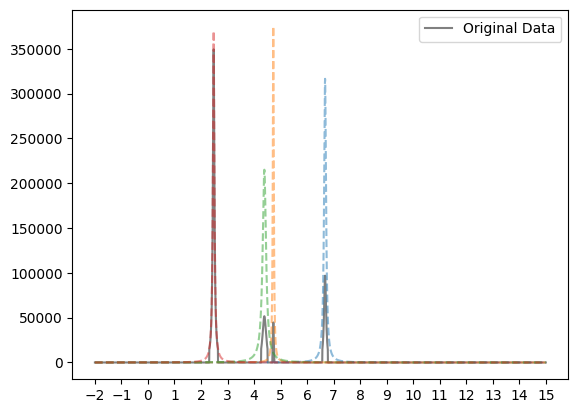

In [34]:
# bring the data back to the cpu
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")
data_test_tensor = data_test_tensor.to("cpu")

target_train_tensor = target_train_tensor.to("cpu")
target_val_tensor = target_val_tensor.to("cpu")
target_test_tensor = target_test_tensor.to("cpu")

data_train_tensor = data_train_tensor.squeeze(1)
data_val_tensor = data_val_tensor.squeeze(1)
# scale the data back
data_train = data_scaler.inverse_transform(data_train_tensor)
data_val = data_scaler.inverse_transform(data_val_tensor)
target_train = target_scaler.inverse_transform(target_train_tensor)


print(f'data_train: {data_train.shape}')
print(f'data_val: {data_val.shape}')
print(f'target_train: {target_train.shape}')

print(f'len substrates_list: {len(substrates_list)}')


x0_parms_train, gamma_parms_train, height_parms_train = np.split(target_train, 3, axis=1)
x0_parms_val, gamma_parms_val, height_parms_val = np.split(target_val, 3, axis=1)
x0_parms_test, gamma_parms_test, height_parms_test = np.split(target_test, 3, axis=1)




n = 30
x = x_data[n]
# plot the data
#plt.plot(x, data_train[n, :], '-', label='Original Data')
# for x0, gamma, height in zip(x0_parms_train[n], gamma_parms_train[n], height_parms_train[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)

# plt.plot(x, data_val[n, :], '-', label='Original Data', color='grey')
# for x0, gamma, height in zip(x0_parms_val[n], gamma_parms_val[n], height_parms_val[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)   
    
#fig = plt.figure(figsize=(10, 8))

plt.plot(x, data_test[n, :], '-', label='Original Data', color='grey')
for x0, gamma, height in zip(x0_parms_test[n], gamma_parms_test[n], height_parms_test[n]):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', alpha=0.5)

plt.xticks(np.arange(-2, 16, 1))
plt.legend()
plt.show()

# Validate on real Data

In [35]:
# # Use a dataframe to collect general evaluation results
# results = pd.DataFrame()

# # We will reuse this function. Hence we copy it to mads_dl.py
# def add_regression_eval(results, algorithm, y_train, y_train_pred, y_test, y_test_pred, num_params):
#     '''
#     Create a table with evaluation results
#     of a regression experiment
#     '''
#     for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
#         mse=mean_squared_error(actual, predicted)
#         results= pd.concat([results, pd.DataFrame([{
#             "algorithm": algorithm, 
#             "dataset": dataset,
#             "MSE": mse,
#             "RMSE": math.sqrt(mse),
#             "MAE": mean_absolute_error(actual, predicted),
#             "MAPE": mean_absolute_percentage_error(actual, predicted)*100, # implemented is relative to 1 not to 100
#             "params": num_params
#         }])], ignore_index=True)   
#     return results


# Test on Data

(1, 3000)


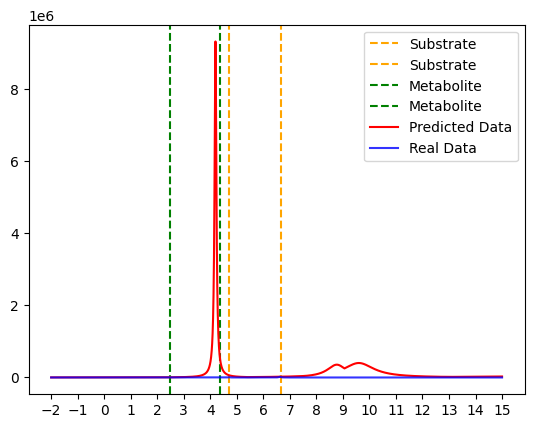

(1, 3000)


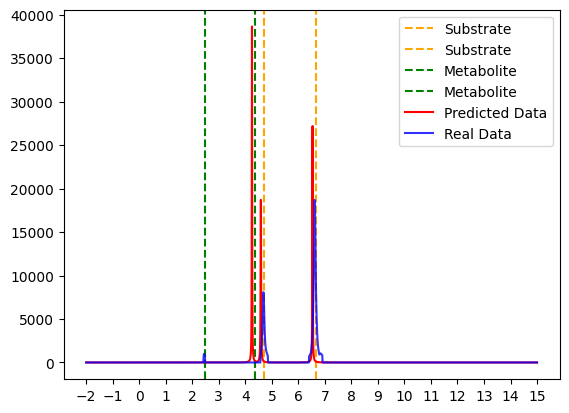

(1, 3000)


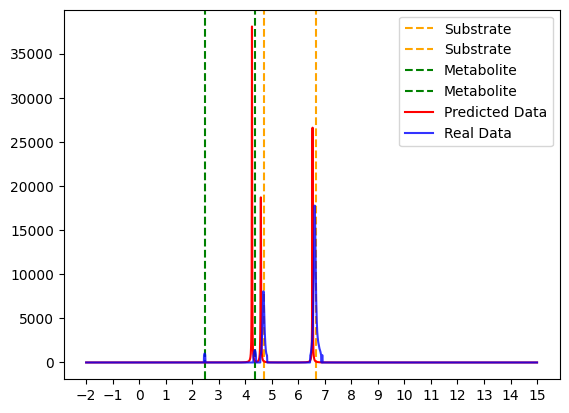

(1, 3000)


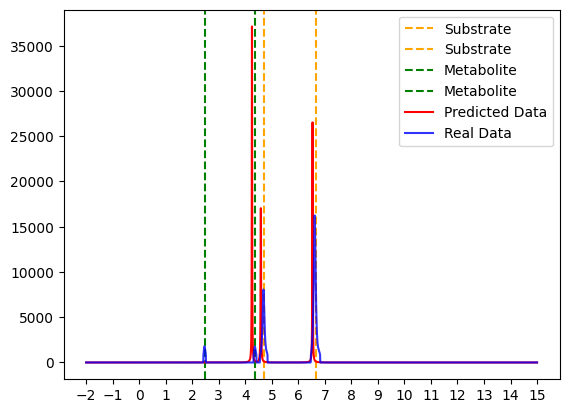

(1, 3000)


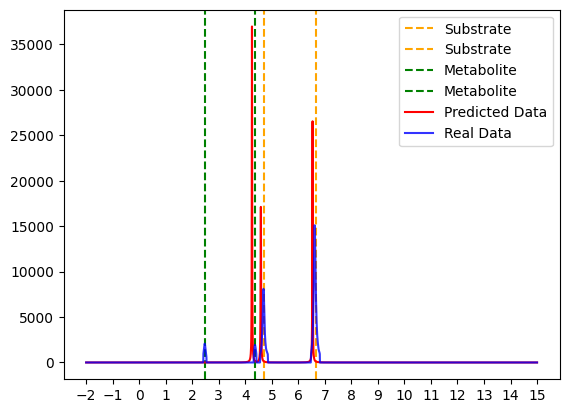

(1, 3000)


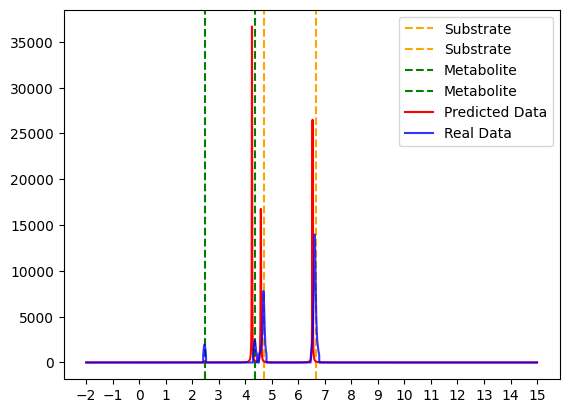

(1, 3000)


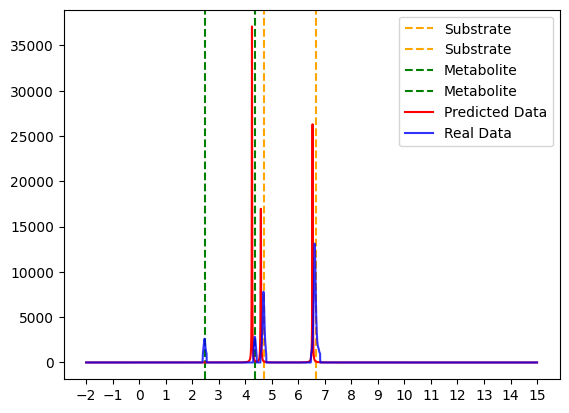

(1, 3000)


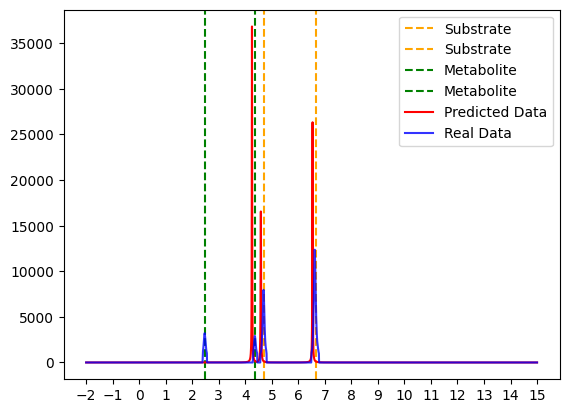

(1, 3000)


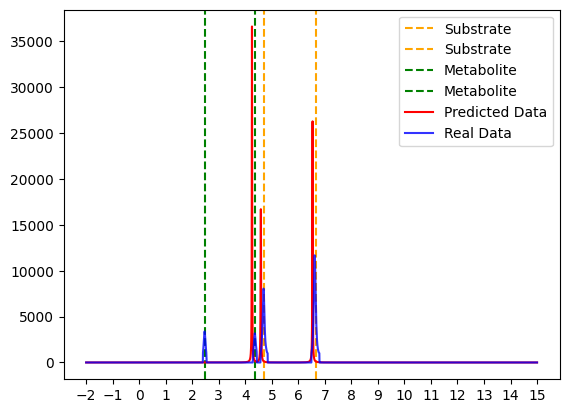

(1, 3000)


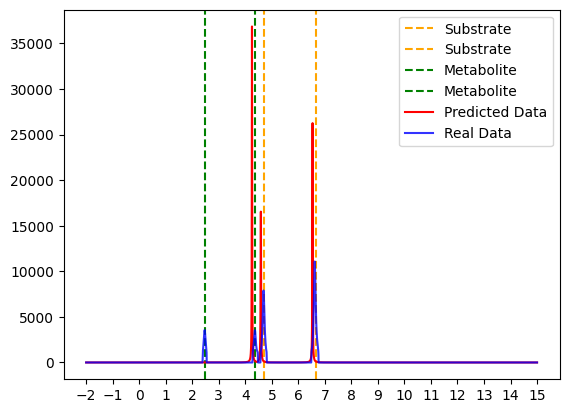

(1, 3000)


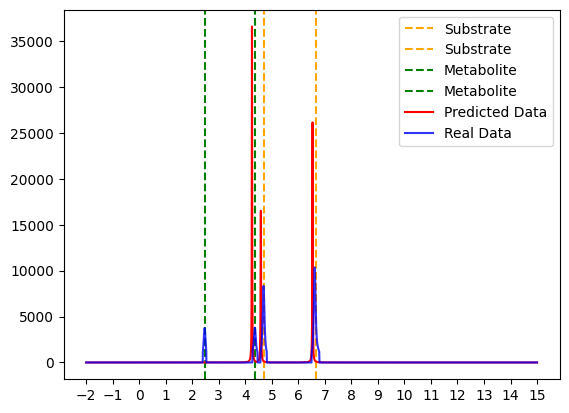

(1, 3000)


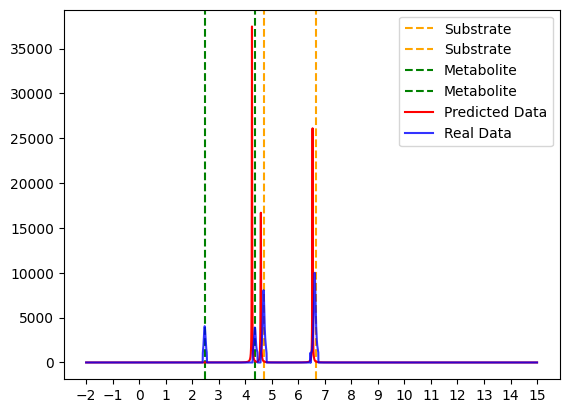

(1, 3000)


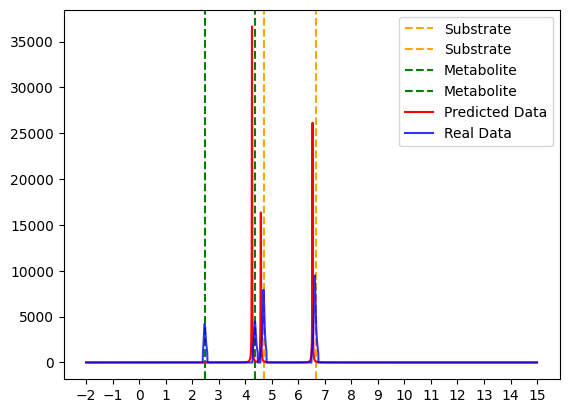

(1, 3000)


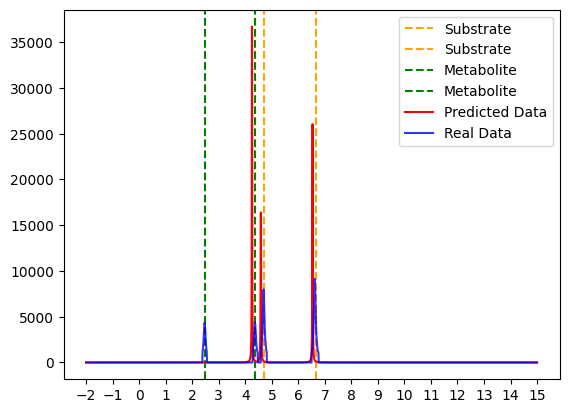

(1, 3000)


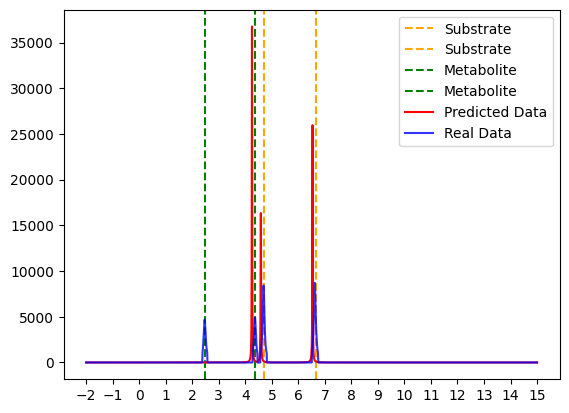

(1, 3000)


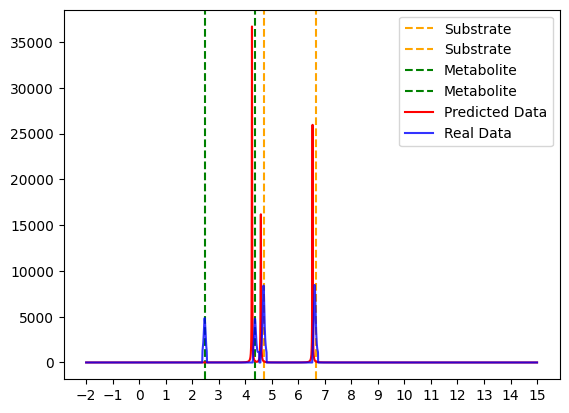

(1, 3000)


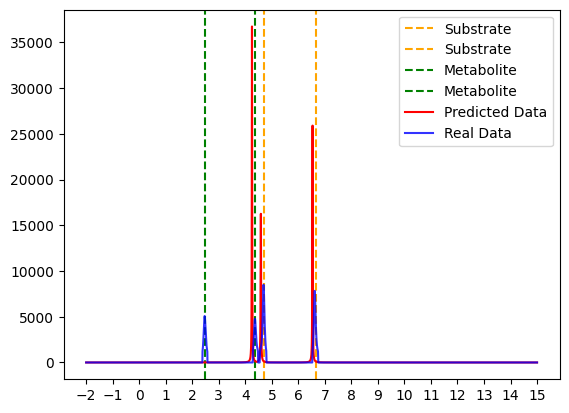

(1, 3000)


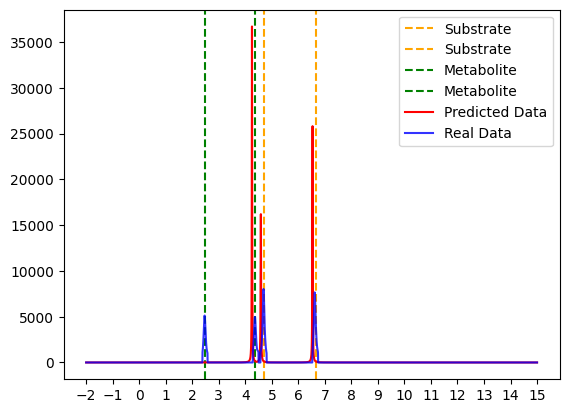

(1, 3000)


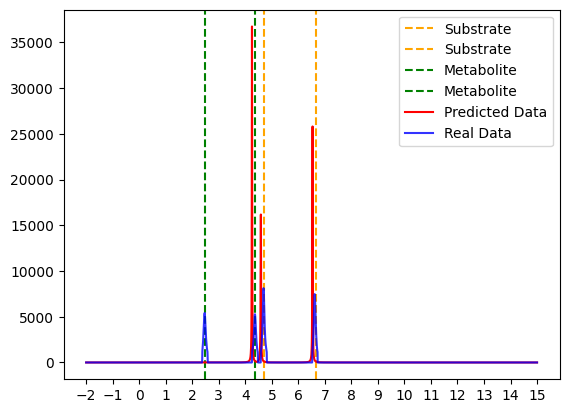

(1, 3000)


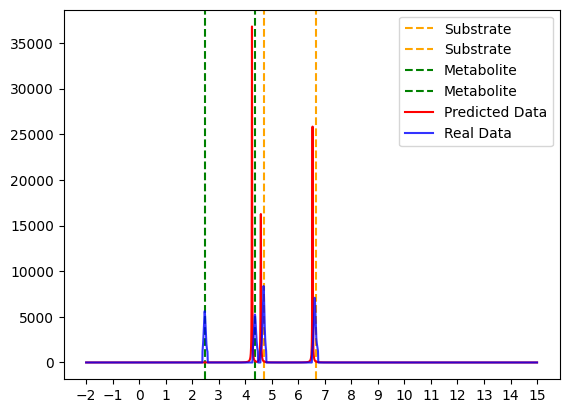

(1, 3000)


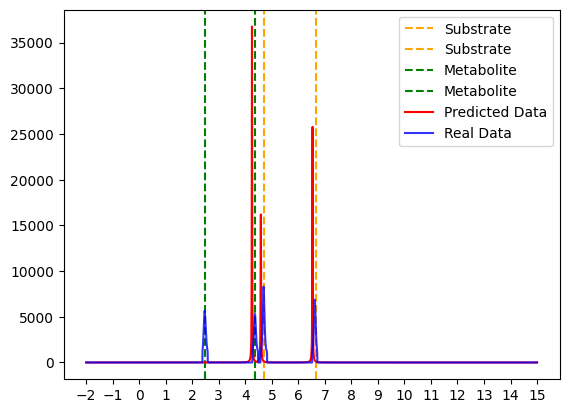

(1, 3000)


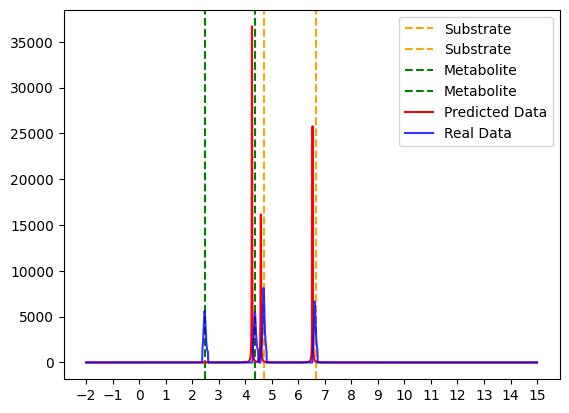

(1, 3000)


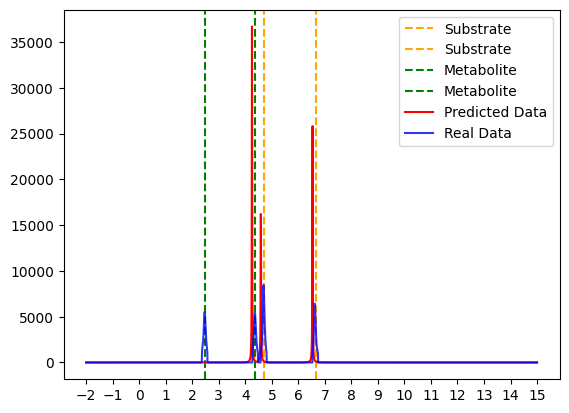

(1, 3000)


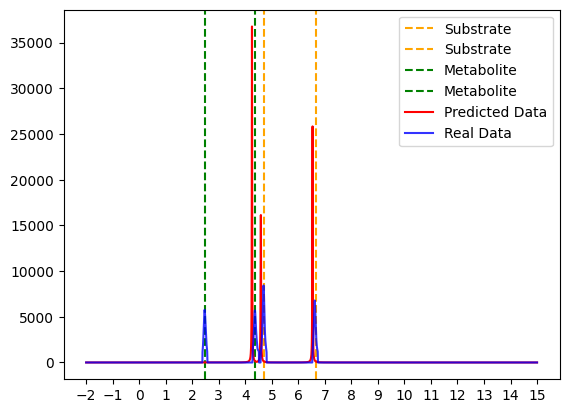

(1, 3000)


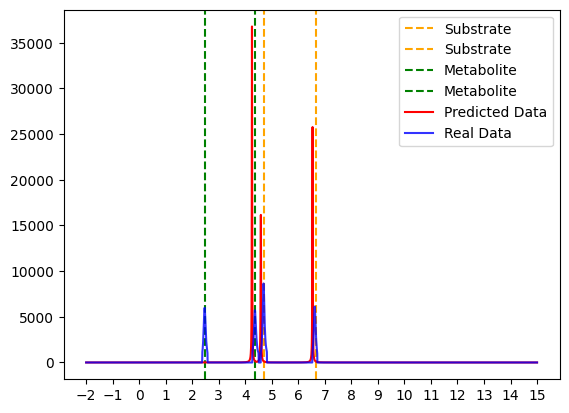

(1, 3000)


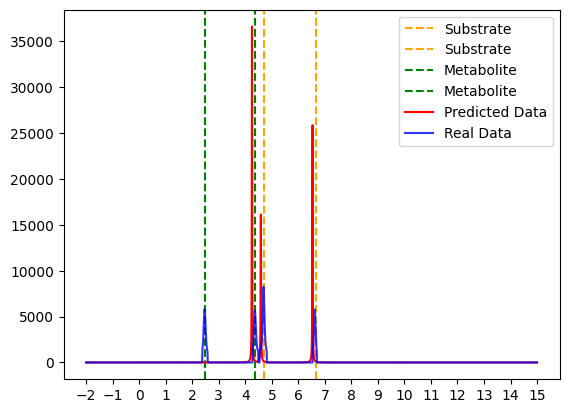

(1, 3000)


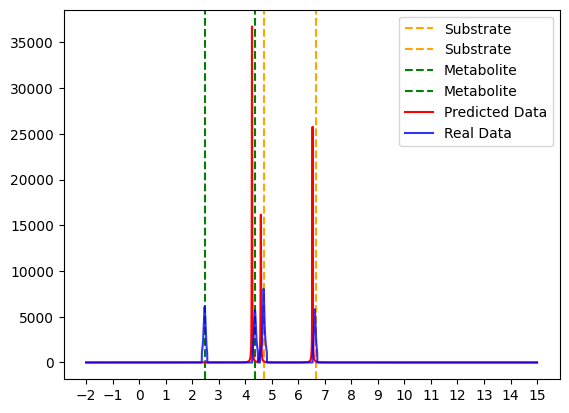

(1, 3000)


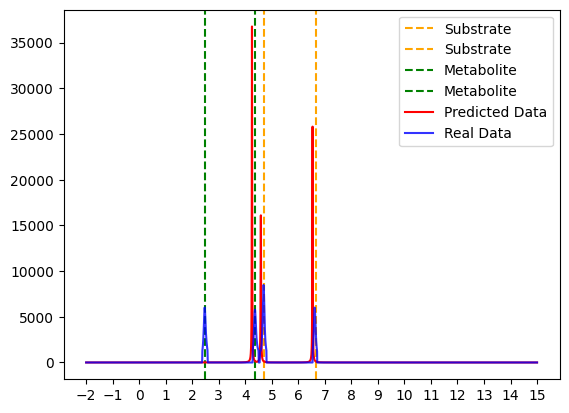

(1, 3000)


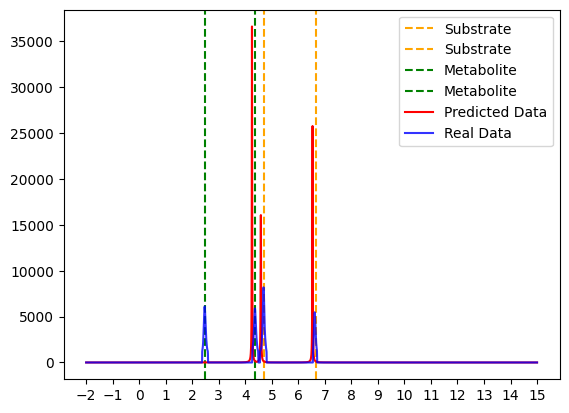

In [36]:
df = pd.read_csv(path_list[0]) 

for i in range(1, 30):
    # fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    #display(df_interpolated)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']

    # scale the data
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))
    print(y_real_sc.shape)

    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32)

    # predict the data
    target_real_pred = model.predict(y_real_tensor)

    # bring the data back to the cpu
    target_real_pred = target_real_pred.cpu().detach().numpy()

    # rescale the data
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred)

    # reshape the data
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)

    x0_parms_real, gamma_parms_real, height_parms_real = np.split(target_real_pred, 3, axis=1)

    # calcualte the mse
    #mse = calculate_mse_of_real_data(df, model, random=False, i=i)
    #print(mse)
    
    # Put the Lorenz functions in a Dataframe
    lorentz_list = []
    lorentz_df = pd.DataFrame({'x': x_real})  # Initialize DataFrame with x_real

    for i, (x0, gamma, height) in enumerate(zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0])):
        lorentz = lorentzian(x_real, x0, gamma, height)
        column_name = f'lorentz_{i}'  # Dynamically generate a unique column name
        lorentz_df = pd.concat([lorentz_df, pd.DataFrame({column_name: lorentz})], axis=1)

    # add another column which takes the np.maximum of the columns
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    #display(lorentz_df)
    


    for subs in substrates:
        plt.axvline(x=subs, color='orange', linestyle='--', label='Substrate')

    for metab in metabolites:
        plt.axvline(x=metab, color='green', linestyle='--', label='Metabolite')

    
    plt.plot(x_real, lorentz_df['max'], label='Predicted Data', color='red')
    plt.plot(x_real, y_real, label='Real Data', color='blue', alpha=0.8)

    plt.xticks(np.arange(-2, 16, 1))
    plt.legend()
    plt.show()

In [37]:
substrates, metabolites

([6.653, 4.7], [4.368, 2.474])